##Crawl Data from Annual Report

In [ ]:
!apt install unoconv
!pip install tesseract
!pip install pytesseract
!pip install pdf2image
!sudo apt-get install poppler-utils
!apt install tesseract-ocr
!apt install tesseract-ocr-vie
!pip install requests
!pip install python-docx
!pip install rarfile
!pip install pymupdf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  apparmor dictionaries-common fonts-liberation2 fonts-opensymbol hunspell-en-us libabsl20210324
  libabw-0.1-1 libcdr-0.1-1 libclucene-contribs1v5 libclucene-core1v5 libcolamd2 libe-book-0.1-1
  libeot0 libepubgen-0.1-1 libetonyek-0.1-1 libexttextcat-2.0-0 libexttextcat-data
  libfreehand-0.1-1 libgpgme11 libgpgmepp6 libharfbuzz-icu0 libhunspell-1.7-0 libhyphen0
  liblangtag-common liblangtag1 libmhash2 libmspub-0.1-1 libmwaw-0.3-3 libmythes-1.2-0
  libodfgen-0.1-1 liborcus-0.17-0 liborcus-parser-0.17-0 libpagemaker-0.0-0 libraptor2-0 librasqal3
  librdf0 libreoffice-base-core libreoffice-calc libreoffice-common libreoffice-core
  libreoffice-draw libreoffice-impress libreoffice-math libreoffice-style-colibre
  libreoffice-writer librevenge-0.0-0 libsuitesparseconfig5 libtext-iconv-perl libuno-cppu3
  libuno-cppuhelpergcc3-3 libuno-purpe

In [ ]:
!pip install pymupdf

In [ ]:
import pytesseract
import subprocess
import os
import requests
import re
import rarfile
import zipfile
from pdf2image import convert_from_path
from docx import Document
from openpyxl import Workbook
import fitz

def get_html_content(url):
    print(url)
    try:
        # Send a HTTP GET request to the URL
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            # Return the content of the response
            return response.text
        else:
            print(f"Failed to retrieve content. Status code: {response.status_code}")
            return None
    except requests.RequestException as e:
        print(f"An error occurred: {e}")
        return None

def extract_links(text):
    # Define the regex pattern to match the desired URL format
    patternPdf = r'https://[^\s]+\.pdf'
    patternDoc = r'https://[^\s]+\.doc'
    patternRar = r'https://[^\s]+\.rar'
    patternZip = r'https://[^\s]+\.zip'

    # Find all matches in the input text
    matchesPdf = re.findall(patternPdf, text)
    matchesDoc = re.findall(patternDoc, text)
    matchesRar = re.findall(patternRar, text)
    matchesZip = re.findall(patternZip, text)

    return matchesPdf + matchesDoc + matchesRar + matchesZip

def read_text_file(file_path):
    print('read_text_file ' + file_path)
    try:
        # Open the file in read mode
        with open(file_path, 'r', encoding='utf-8') as file:
            # Read the content of the file
            content = file.read()
        return content
    except FileNotFoundError:
        print(f"The file at {file_path} was not found.")
        return None
    except IOError:
        print(f"An error occurred while reading the file at {file_path}.")
        return None

def download_file(url, folder_path):
    print('download_file ' + url)
    # Ensure the folder exists
    os.makedirs(folder_path, exist_ok=True)

    # Extract the file name from the URL
    file_name = url.split('/')[-1]
    file_path = os.path.join(folder_path, file_name)

    # Send a HTTP request to the URL
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Write the content to a file
        with open(file_path, 'wb') as file:
            file.write(response.content)
        print(f"File downloaded and saved as: {file_path}")
    else:
        print(f"Failed to download file from {url}, status code: {response.status_code}")


def read_pdf(file_path):
    print("read_pdf " + file_path)
    document = fitz.open(file_path)

    # Extract text from each image (page)
    extracted_text = ''
    for page_number in range(len(document)):
        page = document.load_page(page_number)

        # Extract text from the page
        text = ''
        text = page.get_text()

        print("get text ", text)

        if text.strip() == '':
            print("read_scan_pdf " + file_path + " page " + str(page_number))
            image_pages = convert_from_path(file_path, 600, first_page=page_number+1, last_page=page_number+1)
            ocr_text = pytesseract.image_to_string(image_pages[0], lang='vie')
            text = ocr_text

        extracted_text = extracted_text + text

    return extracted_text

def remove_illegal_characters(text):
    # Define a regular expression pattern to match illegal characters
    illegal_char_pattern = r'[\x00-\x08\x0B-\x0C\x0E-\x1F]'

    # Replace illegal characters with an empty string
    cleaned_text = re.sub(illegal_char_pattern, '', text)
    return cleaned_text


def crawl(code):
  # content = get_html_content('https://finance.vietstock.vn/'+code+'/documents.htm?doctype=2')
  content = read_text_file(code + '.html')
  print(content)
  links = extract_links(content)
  for link in links:
    download_file(link, code)

def extract(code):
    folder_path = code
    # Check if the folder exists
    if not os.path.exists(folder_path):
        print(f"Folder '{folder_path}' does not exist.")
        return

    # Get a list of all files in the folder
    files = os.listdir(folder_path)

    wb = Workbook()

    # Select the active worksheet
    ws = wb.active

    ws.append(["Code", "File Name", "Text Content"])
    # Loop through each file in the folder
    for file_name in files:
        # Construct the full file path
        file_path = os.path.join(folder_path, file_name)

        # Check if the file is a regular file
        if os.path.isfile(file_path):
            _, ext = os.path.splitext(file_path)
            text = ''
            if ext.lower() == '.pdf':
                text = read_pdf(file_path)

            text = text.encode('utf-8', errors='ignore').decode('utf-8')
            text = remove_illegal_characters(text)
            if text != '':
                print("Done " + file_path)
                ws.append([code, file_name, text])

    wb.save(code + '.xlsx')
    print(f"Excel file saved as: {code + '.xlsx'}")

In [ ]:
crawl('PLX')

read_text_file PLX.html
<!DOCTYPE html>
<!-- saved from url=(0042)https://www.petrolimex.com.vn/reports.html -->
<html xmlns="http://www.w3.org/1999/xhtml" lang="en"><head><meta http-equiv="Content-Type" content="text/html; charset=UTF-8"><title>Reports</title><meta name="viewport" content="width=device-width, initial-scale=1"><link rel="canonical" href="https://www.petrolimex.com.vn/reports.html"><link rel="preconnect" href="https://portals.petrolimex.com.vn/"><link rel="preconnect" href="https://files.petrolimex.com.vn/"><link rel="preconnect" href="https://fonts.googleapis.com/"><link rel="preconnect" href="https://fonts.gstatic.com/"><link rel="preconnect" href="https://www.googletagmanager.com/"><link rel="preconnect" href="https://unpkg.com/"><link rel="preconnect" href="https://cdnjs.cloudflare.com/"><meta name="description" content="Cổng thông tin chính thức của Petrolimex - Tập đoàn Xăng dầu Việt Nam"><meta name="keywords" content="petrolimex, plx, giá bán lẻ xăng dầu, điều ch

In [ ]:
extract('PLX')

##News Scraping in Google

In [ ]:
import json
import pandas as pd
from gnews import GNews
from newspaper import Article

start_year = 2019
end_year = 2024

df = pd.DataFrame(columns=['Title', 'Published Date', 'Publisher', 'Description', 'URL', 'Article Text'])

for year in range(start_year, end_year):
    google_news = GNews(language='vi', country='VN', period='1y', start_date=(year, 1, 1), end_date=(year+1, 1, 1), max_results=1000)

    json_resp = google_news.get_news('"ACB"')

    with open(f'data_{year}.json', 'w', encoding='utf-8') as f:
        json.dump(json_resp, f, ensure_ascii=False)

    data = json.load(open(f'data_{year}.json', encoding='utf-8'))

    for item in data:
        try:
            article = Article(item['url'])
            article.download()
            article.parse()
            title = item['title']
            published_date = item['published date']
            publisher = item['publisher']
            description = item['description']
            url = item['url']
            article_text = article.text
            df = df.append({'Title': title, 'Published Date': published_date, 'Publisher': publisher, 'Description': description, 'URL': url, 'Article Text': article_text}, ignore_index=True)
        except:
            print('error')
            continue

excel_file = 'ACB.xlsx'
df.to_excel(excel_file, index=False)
print(f"Data has been combined and saved to {excel_file}.")

##PRE-PROCESSING DATA

###PRICE DATA

In [133]:
import pandas as pd

In [134]:
df_price_ACB = pd.read_excel('ACB-Historical-Data.xlsx')
df_price_BCM = pd.read_excel('BCM-Historical-Data.xlsx')
df_price_BID = pd.read_excel('BID-Historical-Data.xlsx')
df_price_BVH = pd.read_excel('BVH-Historical-Data.xlsx')
df_price_CTG = pd.read_excel('CTG-Historical-Data.xlsx')
df_price_GVR = pd.read_excel('GVR-Historical-Data.xlsx')
df_price_HDB = pd.read_excel('HDB-Historical-Data.xlsx')
df_price_HPG = pd.read_excel('HPG-Historical-Data.xlsx')
df_price_VHM = pd.read_excel('VHM-Historical-Data.xlsx')
df_price_VJC = pd.read_excel('VJC-Historical-Data.xlsx')

In [135]:
df_price = pd.concat([df_price_ACB, df_price_BCM, df_price_BID, df_price_BVH, df_price_CTG, df_price_GVR, df_price_HDB,
                     df_price_HPG, df_price_VHM, df_price_VJC], axis=0, ignore_index=True)

In [136]:
print(df_price)

             Date Code     Price      Open      High       Low           Vol  \
0      12/29/2023  ACB   23900.0   23900.0   24100.0   23800.0  9.200000e+09   
1      12/28/2023  ACB   23750.0   23300.0   23950.0   23300.0  1.051000e+10   
2      12/27/2023  ACB   23300.0   23200.0   23400.0   23200.0  4.870000e+09   
3      12/26/2023  ACB   23250.0   23400.0   23400.0   23250.0  5.730000e+09   
4      12/25/2023  ACB   23350.0   23250.0   23450.0   23200.0  7.580000e+09   
...           ...  ...       ...       ...       ...       ...           ...   
12474  01/08/2019  VJC  115000.0  116300.0  116300.0  114500.0  2.266500e+05   
12475  01/07/2019  VJC  116000.0  116300.0  116400.0  113100.0  6.375900e+05   
12476  01/04/2019  VJC  115000.0  115000.0  116300.0  113300.0  8.820800e+05   
12477  01/03/2019  VJC  116200.0  117000.0  117500.0  115000.0  5.795900e+05   
12478  01/02/2019  VJC  117000.0  120000.0  121300.0  116000.0  5.099200e+05   

       Change %  
0        0.0063  
1  

###NEWS DATA

In [85]:
df_news_ACB = pd.read_excel('ACB.xlsx')
df_news_BCM = pd.read_excel('BCM.xlsx')
df_news_BID = pd.read_excel('BID.xlsx')
df_news_BVH = pd.read_excel('BVH.xlsx')
df_news_CTG = pd.read_excel('CTG.xlsx')
df_news_GVR = pd.read_excel('GVR.xlsx')
df_news_HDB = pd.read_excel('HDB.xlsx')
df_news_HPG = pd.read_excel('HPG.xlsx')
df_news_VHM = pd.read_excel('VHM.xlsx')
df_news_VJC = pd.read_excel('VJC.xlsx')

In [86]:
# concat on date and ticker
df_news = pd.concat([df_news_ACB, df_news_BCM, df_news_BID, df_news_BVH, df_news_CTG, df_news_GVR, df_news_HDB,
                         df_news_HPG, df_news_VHM, df_news_VJC], axis=0, ignore_index=True)

In [87]:
print(df_news)

                               Date Published Year  Code  \
0     Thu, 19 Dec 2019 08:00:00 GMT           2019  ACB    
1     Sat, 02 Feb 2019 08:00:00 GMT           2019  ACB    
2     Sat, 19 Oct 2019 07:00:00 GMT           2019  ACB    
3     Thu, 26 Dec 2019 08:00:00 GMT           2019  ACB    
4     Fri, 15 Nov 2019 08:00:00 GMT           2019  ACB    
...                             ...            ...   ...   
8066  Wed, 16 Feb 2022 08:00:00 GMT           2022   VJC   
8067  Thu, 08 Dec 2022 08:00:00 GMT           2022   VJC   
8068  Wed, 27 Jul 2022 07:00:00 GMT           2022   VJC   
8069  Mon, 04 Jul 2022 07:00:00 GMT           2022   VJC   
8070  Thu, 20 Oct 2022 07:00:00 GMT           2022   VJC   

                                               Title_EN  
0     How Mr. Kien was accused of manipulating ACB b...  
1     Elected Kien to prison, Tran Mong Hung's famil...  
2     "Super cheat" appropriated 719 billion VND fro...  
3     Dramatic banking transaction dispute - Tu

###Change date type

Because the data is drawn from different pages, it can lead to different date formats, so run a test for each df.

In [88]:
df_news['Date'] = pd.to_datetime(df_news_ACB['Date'], format='%a, %d %b %Y %H:%M:%S GMT').dt.strftime('%Y/%m/%d')
df_news['Date'] = pd.to_datetime(df_news_BCM['Date'], format='%a, %d %b %Y %H:%M:%S GMT').dt.strftime('%Y/%m/%d')
df_news['Date'] = pd.to_datetime(df_news_BID['Date'], format='%a, %d %b %Y %H:%M:%S GMT').dt.strftime('%Y/%m/%d')
df_news['Date'] = pd.to_datetime(df_news_BVH['Date'], format='%a, %d %b %Y %H:%M:%S GMT').dt.strftime('%Y/%m/%d')
df_news['Date'] = pd.to_datetime(df_news_CTG['Date'], format='%a, %d %b %Y %H:%M:%S GMT').dt.strftime('%Y/%m/%d')
df_news['Date'] = pd.to_datetime(df_news_HDB['Date'], format='%a, %d %b %Y %H:%M:%S GMT').dt.strftime('%Y/%m/%d')
df_news['Date'] = pd.to_datetime(df_news_HPG['Date'], format='%a, %d %b %Y %H:%M:%S GMT').dt.strftime('%Y/%m/%d')
df_news['Date'] = pd.to_datetime(df_news_VHM['Date'], format='%a, %d %b %Y %H:%M:%S GMT').dt.strftime('%Y/%m/%d')

In [89]:
# Assuming your 'Date' column is in the df_news_GVR DataFrame
df_news['Date'] = pd.to_datetime(df_news_GVR['Date'], format='%a, %d %b %Y %H:%M:%S GMT', errors='coerce')

# Handle the NaT values
df_news['Date'] = df_news['Date'].fillna(pd.Timestamp('2018-06-28'))

In [90]:
# Assuming your 'Date' column is in the df_news_VJC DataFrame
df_news['Date'] = pd.to_datetime(df_news_VJC['Date'], format='%a, %d %b %Y %H:%M:%S GMT', errors='coerce')

# Handle the NaT values
df_news['Date'] = df_news['Date'].fillna(pd.Timestamp('2022-07-20'))

In [91]:
df_news['Date'] = pd.to_datetime(df_news['Date']).dt.strftime('%Y/%m/%d')

In [92]:
print(df_news)

            Date Published Year  Code  \
0     2019/11/30           2019  ACB    
1     2019/10/14           2019  ACB    
2     2019/05/02           2019  ACB    
3     2019/02/20           2019  ACB    
4     2019/04/10           2019  ACB    
...          ...            ...   ...   
8066  2022/07/20           2022   VJC   
8067  2022/07/20           2022   VJC   
8068  2022/07/20           2022   VJC   
8069  2022/07/20           2022   VJC   
8070  2022/07/20           2022   VJC   

                                               Title_EN  
0     How Mr. Kien was accused of manipulating ACB b...  
1     Elected Kien to prison, Tran Mong Hung's famil...  
2     "Super cheat" appropriated 719 billion VND fro...  
3     Dramatic banking transaction dispute - Tuoi Tr...  
4     Thousands of bank employees lost their jobs - ...  
...                                                 ...  
8066  Vietjet cooperates to digitize the entire proc...  
8067  VNDirect: With the advantage of low-c

##LOADING STOCK PRICE HISTORY

In [77]:
import pandas as pd

In [137]:
# Convert the 'Date' column to datetime
df_price['Date'] = pd.to_datetime(df_price['Date'])

# Sort the DataFrame by 'Date'
df_price = df_price.sort_values(['Code', 'Date'])
df_price = df_price.set_index('Date')
df_price.head()

,Code,Price,Open,High,Low,Vol,Change %
Date,,,,,,,
2019-01-02,ACB,11058.0,11209.5,11209.5,10944.4,2.910000e+09,-0.0135
2019-01-03,ACB,10641.4,9959.8,11020.1,9959.8,5.170000e+09,-0.0377
2019-01-04,ACB,10717.2,10603.6,10792.9,10452.1,7.320000e+09,0.0071
2019-01-07,ACB,10868.6,10944.4,10944.4,10792.9,3.450000e+09,0.0141
2019-01-08,ACB,10792.9,11891.1,11891.1,10792.9,2.230000e+09,-0.0070


In [138]:
print(df_price.dtypes)

Code         object
Price       float64
Open        float64
High        float64
Low         float64
Vol         float64
Change %    float64
dtype: object


In [139]:
code = list(df_price['Code'].unique())
print(code)

['ACB', 'BCM', 'BID', 'BVH', 'CTG', 'GVR', 'HDB', 'HPG', 'VHM', 'VJC']


In [81]:
import matplotlib.pyplot as plt
import plotly.express as px

In [140]:
# Create the line plot with facets
fig = px.line(df_price, y= 'Price', facet_col='Code',
              facet_col_wrap=3, height=900, template='plotly_white')

# Update the trace properties
fig.update_traces(line_color='#FF6969', line_width=2)

# Display the plot
fig.show()

In [83]:
df_price.describe()

,level_0,index,Price,Open,High,Low,Vol,Change %,ret_curr,eventRet
count,12479.000000,12479.000000,12479.000000,12479.000000,12479.000000,12479.000000,1.247300e+04,12479.000000,12478.000000,12477.000000
mean,6239.000000,6239.000000,42155.715033,42137.600649,42663.623159,41564.640997,7.496607e+08,0.000556,0.000662,0.001327
std,3602.521339,3602.521339,32403.507898,32373.371420,32636.744045,32007.168260,2.947079e+09,0.022294,0.032567,0.046670
min,0.000000,0.000000,6690.900000,6787.900000,6787.900000,6244.800000,0.000000e+00,-0.175200,-0.654723,-0.688728
25%,3119.500000,3119.500000,18400.000000,18412.550000,18682.000000,18100.000000,6.812000e+05,-0.009400,-0.009418,-0.013866
50%,6239.000000,6239.000000,30690.300000,30663.200000,31147.000000,30259.700000,2.360000e+06,0.000000,0.000000,0.000052
75%,9358.500000,9358.500000,56044.000000,56044.000000,56869.000000,55204.000000,8.150000e+06,0.010400,0.010415,0.016559
max,12478.000000,12478.000000,149000.000000,148200.000000,149000.000000,147500.000000,4.873000e+10,0.125700,1.708333,1.701496


##LOADING NEWS HEADLINE DATA

In [98]:
df_news['Date'] = pd.to_datetime(df_news['Date'], format='%Y/%m/%d')
print(df_news)

           Date Published Year  Code  \
0    2019-11-30           2019  ACB    
1    2019-10-14           2019  ACB    
2    2019-05-02           2019  ACB    
3    2019-02-20           2019  ACB    
4    2019-04-10           2019  ACB    
...         ...            ...   ...   
8066 2022-07-20           2022   VJC   
8067 2022-07-20           2022   VJC   
8068 2022-07-20           2022   VJC   
8069 2022-07-20           2022   VJC   
8070 2022-07-20           2022   VJC   

                                               Title_EN  
0     How Mr. Kien was accused of manipulating ACB b...  
1     Elected Kien to prison, Tran Mong Hung's famil...  
2     "Super cheat" appropriated 719 billion VND fro...  
3     Dramatic banking transaction dispute - Tuoi Tr...  
4     Thousands of bank employees lost their jobs - ...  
...                                                 ...  
8066  Vietjet cooperates to digitize the entire proc...  
8067  VNDirect: With the advantage of low-cost airli...

In [99]:
# We can preread the data
df_news.head()

,Date,Published Year,Code,Title_EN
0,2019-11-30,2019,ACB,How Mr. Kien was accused of manipulating ACB b...
1,2019-10-14,2019,ACB,"Elected Kien to prison, Tran Mong Hung's famil..."
2,2019-05-02,2019,ACB,"""Super cheat"" appropriated 719 billion VND fro..."
3,2019-02-20,2019,ACB,Dramatic banking transaction dispute - Tuoi Tr...
4,2019-04-10,2019,ACB,Thousands of bank employees lost their jobs - ...


In [100]:
df_news = df_news[~(df_news['Code'] == '')]
df_news.shape

(8071, 4)

In [101]:
px.bar(df_news['Code'].value_counts()[:100],template="plotly_white")

##EVENT RETURN

In [104]:
df_price['Date'] = pd.to_datetime(df_price['Date'], format='%Y/%m/%d')
print(df_price)

            Date  level_0  index Code     Price      Open      High       Low  \
0     2019-01-02        0   1244  ACB   11058.0   11209.5   11209.5   10944.4   
1     2019-01-03        1   1243  ACB   10641.4    9959.8   11020.1    9959.8   
2     2019-01-04        2   1242  ACB   10717.2   10603.6   10792.9   10452.1   
3     2019-01-07        3   1241  ACB   10868.6   10944.4   10944.4   10792.9   
4     2019-01-08        4   1240  ACB   10792.9   11891.1   11891.1   10792.9   
...          ...      ...    ...  ...       ...       ...       ...       ...   
12474 2023-12-25    12474  11233  VJC  107800.0  106700.0  107800.0  106500.0   
12475 2023-12-26    12475  11232  VJC  108000.0  108000.0  108200.0  107500.0   
12476 2023-12-27    12476  11231  VJC  107900.0  108100.0  108100.0  107500.0   
12477 2023-12-28    12477  11230  VJC  108000.0  107800.0  108000.0  106400.0   
12478 2023-12-29    12478  11229  VJC  108000.0  108000.0  108000.0  107000.0   

                Vol  Change

In [102]:
#Computing the return
df_price['ret_curr'] =df_price['Price'].pct_change()

#Computing the event return
# rtm1 = df_proce['ret_curr'].shift(-1) # return a day before the news
rtp1 = df_price['ret_curr'].shift(1) # return a day after the news
rt = df_price['ret_curr'] # return the day of the news

df_price['eventRet'] =  rt + rtp1
df_price.reset_index(level=0, inplace=True)

df_price['Date'] = pd.to_datetime(df_price['Date']).apply(lambda x: x.date())

In [105]:
# Merge the DataFrames on 'Code' and 'Date'
df_all = pd.merge(df_news, df_price,
                  how='left',
                  on=['Code', 'Date'])

# Filter the DataFrame to only include the desired codes
codes = df_news['Code'].unique()
df_all = df_all[df_all['Code'].isin(codes)]

# Select the desired columns
df_all = df_all[['Code', 'Title_EN', 'Date', 'eventRet', 'Price']]

# Drop rows with NaN values
df_all = df_all.dropna()

# Reset the index
df_all = df_all.reset_index(drop=True)

# Save the combined DataFrame to a CSV file
df_all.to_csv('combined.csv', index=False)

In [106]:
# preread combined dataframe
data_df = pd.read_csv('combined.csv')
data_df = data_df.dropna()
data_df.head()

,Code,Title_EN,Date,eventRet,Price
0,BCM,Prime Minister Nguyen Tan Dung attended the gr...,2022-10-05,0.002635,89491.0
1,BCM,"Becamex IDC - ""Cheabol"" of Binh Duong - VTV",2022-07-11,-0.008348,58635.0
2,BCM,Signing a cooperation agreement between Became...,2022-09-21,-0.010293,95543.0
3,BCM,Opening ceremonies for the 2019-2019 school ye...,2022-03-08,-0.052640,74212.0
4,BCM,100 million apartment in Binh Duong: Who can b...,2022-01-19,0.030924,72128.0


In [107]:
print(data_df.shape, data_df.Code.unique().shape)

(5339, 5) (8,)


##SENTIMENT EVALUATION

In [108]:
from textblob import TextBlob
data_df['sent_blob'] = data_df['Title_EN'].apply(lambda row: TextBlob(row).sentiment.polarity)
print(data_df)

     Code                                           Title_EN        Date  \
0     BCM  Prime Minister Nguyen Tan Dung attended the gr...  2022-10-05   
1     BCM        Becamex IDC - "Cheabol" of Binh Duong - VTV  2022-07-11   
2     BCM  Signing a cooperation agreement between Became...  2022-09-21   
3     BCM  Opening ceremonies for the 2019-2019 school ye...  2022-03-08   
4     BCM  100 million apartment in Binh Duong: Who can b...  2022-01-19   
...   ...                                                ...         ...   
5334  VJC  Vietjet cooperates to digitize the entire proc...  2022-07-20   
5335  VJC  VNDirect: With the advantage of low-cost airli...  2022-07-20   
5336  VJC  Vietjet launches nearly 30,000 zero-dollar tic...  2022-07-20   
5337  VJC  Fukuoka and Nagoya (Japan) warmly welcome Viet...  2022-07-20   
5338  VJC  Vietjet operates more than 86,000 flights in 9...  2022-07-20   

      eventRet     Price  sent_blob  
0     0.002635   89491.0       0.00  
1    -0.008

In [141]:
fig = px.scatter(data_df,x='sent_blob',y='eventRet',
                 facet_col='Code',facet_col_wrap=3,
                 template='plotly_white',
                 width=None,height=1000,
                 title='event return & textblob sentiment scatter plot')
fig.update_traces(marker=dict(size=5,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  opacity=0.3,
                  selector=dict(mode='markers'))

fig.show()

##SENTIMENT LABELS

###Manually labelled Supervised Learning (SL) Models

In [110]:
from nltk.tokenize import word_tokenize
from copy import deepcopy
from textblob import TextBlob

class make_labels:

    def __init__(self,df,corpus):
        self.df = df
        self.corpus = corpus

    @staticmethod
    def isfloat(element: any) -> bool:
        #If you expect None to be passed:
        if element is None:
            return False
        try:
            float(element)
            return True
        except ValueError:
            return False

    def percentage_val(self,ldf,text):

        ldf = deepcopy(ldf)
        ldf['perc_sent'] = None

        for index,row in ldf.iterrows():

            # tokenise document
            tokens = word_tokenize(row[text])

            # find values with percentage
            for ii,token in enumerate(tokens):

                # only if a % is found

                if(token is '%'):

                    if(tokens[ii-1] is 'a'):
                        ldf._set_value(index,'perc_sent',True)
                        pass

                    elif('-' in tokens[ii-1] and tokens[ii-1].split('-')[0] is ''):

                        val = float(tokens[ii-1])
                        ldf._set_value(index,'perc_sent',False)

                    # two values separated by dash - (range of values)

                    elif('-' in tokens[ii-1] and tokens[ii-1].split('-')[0] is not ''):

                        val0 = tokens[ii-1].split('-')[0]
                        val1 = tokens[ii-1].split('-')[1]

                        # if both values are integers
                        if(val0.isnumeric() and val1.isnumeric()):

                            val = (float(val0) + float(val1))/2
                            ldf._set_value(index,'perc_sent',True)

                    # approximate value

                    elif('~' in tokens[ii-1]):

                        val0 = tokens[ii-1].replace('~','')
                        val = float(val0)
                        ldf._set_value(index,'perc_sent',True)

                    # value in excess

                    elif('+' in tokens[ii-1]):

                        val0 = tokens[ii-1].replace('+','')
                        val = float(val0)

                        ldf._set_value(index,'perc_sent',True)

                    # if its just a float

                    elif(self.isfloat(tokens[ii-1])):
                        ldf.loc[index,'perc_sent'] = True

                    # if its an integer

                    elif(tokens[ii-1].isnumeric()):

                        ldf.loc[index,'perc_sent'] = True

        return ldf

    def sentiment_val(self,ldf,text):
        ldf = deepcopy(ldf)
        ldf['blob_sent'] = ldf[text].apply(lambda row: TextBlob(row).sentiment.polarity)
        return ldf

    def create_label(self,option):

        if(option is 'percentage'):
            tdf = self.percentage_val(self.df.dropna(),self.corpus)
        elif(option is 'sentiment'):
            tdf = self.sentiment_val(self.df,self.corpus)

        return tdf

<>:37: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<>:39: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<>:43: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<>:50: SyntaxWarning:

"is not" with a literal. Did you mean "!="?

<>:98: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<>:100: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<>:37: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<>:39: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<>:43: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<>:50: SyntaxWarning:

"is not" with a literal. Did you mean "!="?

<>:98: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<>:100: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<ipython-input-110-0c2c375fbf38>:37: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<ipython-input-110-0c2c375fbf38>:39: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<ipython-input-110-0c2c375fbf38>:4

In [111]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [112]:
labels = make_labels(df=data_df,corpus='Title_EN')
tdf = labels.create_label('percentage')
tdf.head()

,Code,Title_EN,Date,eventRet,Price,sent_blob,perc_sent
0,BCM,Prime Minister Nguyen Tan Dung attended the gr...,2022-10-05,0.002635,89491.0,0.0,None
1,BCM,"Becamex IDC - ""Cheabol"" of Binh Duong - VTV",2022-07-11,-0.008348,58635.0,0.0,None
2,BCM,Signing a cooperation agreement between Became...,2022-09-21,-0.010293,95543.0,0.0,None
3,BCM,Opening ceremonies for the 2019-2019 school ye...,2022-03-08,-0.052640,74212.0,0.0,None
4,BCM,100 million apartment in Binh Duong: Who can b...,2022-01-19,0.030924,72128.0,0.0,None


In [113]:
print(tdf.perc_sent.value_counts(dropna=False))

perc_sent
None    5220
True     119
Name: count, dtype: int64


In [114]:
display(tdf[tdf['perc_sent'].isna()].head(1))

,Code,Title_EN,Date,eventRet,Price,sent_blob,perc_sent
0,BCM,Prime Minister Nguyen Tan Dung attended the gr...,2022-10-05,0.002635,89491.0,0.0,None


In [115]:
labels = make_labels(df=tdf,corpus='Title_EN')
tdf = labels.create_label('sentiment')
tdf.head()

,Code,Title_EN,Date,eventRet,Price,sent_blob,perc_sent,blob_sent
0,BCM,Prime Minister Nguyen Tan Dung attended the gr...,2022-10-05,0.002635,89491.0,0.0,None,0.0
1,BCM,"Becamex IDC - ""Cheabol"" of Binh Duong - VTV",2022-07-11,-0.008348,58635.0,0.0,None,0.0
2,BCM,Signing a cooperation agreement between Became...,2022-09-21,-0.010293,95543.0,0.0,None,0.0
3,BCM,Opening ceremonies for the 2019-2019 school ye...,2022-03-08,-0.052640,74212.0,0.0,None,0.0
4,BCM,100 million apartment in Binh Duong: Who can b...,2022-01-19,0.030924,72128.0,0.0,None,0.0


####MANUAL LABELS

In [116]:
tdf[tdf['perc_sent'].isna()]

,Code,Title_EN,Date,eventRet,Price,sent_blob,perc_sent,blob_sent
0,BCM,Prime Minister Nguyen Tan Dung attended the gr...,2022-10-05,0.002635,89491.0,0.00,None,0.00
1,BCM,"Becamex IDC - ""Cheabol"" of Binh Duong - VTV",2022-07-11,-0.008348,58635.0,0.00,None,0.00
2,BCM,Signing a cooperation agreement between Became...,2022-09-21,-0.010293,95543.0,0.00,None,0.00
3,BCM,Opening ceremonies for the 2019-2019 school ye...,2022-03-08,-0.052640,74212.0,0.00,None,0.00
4,BCM,100 million apartment in Binh Duong: Who can b...,2022-01-19,0.030924,72128.0,0.00,None,0.00
...,...,...,...,...,...,...,...,...
5334,VJC,Vietjet cooperates to digitize the entire proc...,2022-07-20,0.010448,125500.0,0.00,None,0.00
5335,VJC,VNDirect: With the advantage of low-cost airli...,2022-07-20,0.010448,125500.0,0.00,None,0.00
5336,VJC,"Vietjet launches nearly 30,000 zero-dollar tic...",2022-07-20,0.010448,125500.0,0.45,None,0.45
5337,VJC,Fukuoka and Nagoya (Japan) warmly welcome Viet...,2022-07-20,0.010448,125500.0,0.80,None,0.80


In [117]:
# index values of headlines which contain ''
tdf = tdf.drop(tdf[tdf['Title_EN'] == ''].index)

####BEATS & MISSES

In [118]:
tdf[tdf['Title_EN'].str.contains('beats')]

,Code,Title_EN,Date,eventRet,Price,sent_blob,perc_sent,blob_sent
2880,HPG,Can Tho beats Dak Lak 3 - 1 at the 2022 Nation...,2022-07-20,-0.010869,20318.0,0.0,None,0.0


In [119]:
tdf.loc[(tdf['Title_EN'].str.contains('misses')),'perc_sent'] = False
tdf.loc[(tdf['Title_EN'].str.contains('beats')),'perc_sent'] = True

In [120]:
# final dataframe
ldf = tdf.loc[~tdf['perc_sent'].isna()]
ldf = ldf.drop(['blob_sent','Price'],axis=1)
ldf['perc_sent'].replace({False:0,True:1},inplace=True)
ldf.head(2)

,Code,Title_EN,Date,eventRet,sent_blob,perc_sent
11,BCM,"Becamex equitization, the state still holds 51...",2022-03-25,-0.023916,0.0,1
33,BID,Increase credit to 22% - Unknown GDP growth an...,2019-05-07,-0.032161,-0.1,1


####EVALUATION FUNCTION

In [121]:
import warnings; warnings.filterwarnings('ignore')
import seaborn as sns; sns.set(style='whitegrid',
                              font_scale=0.7)


class nlp_evals:

    def __init__(self,df,corpus,label,
                 spacy_model='en_core_web_sm',
                 title='accuracy evaluation'
                ):

        self.df = deepcopy(df)
        self.corpus = corpus
        self.label = label
        self.spacy_model = spacy_model
        self.embeddings = self.get_embeddings()
        self.seed = 32
        self.num_folds = 4
        self.title = title

    def get_embeddings(self):

        # NLP pipline
        nlp = spacy.load(self.spacy_model)
        if(self.spacy_model is 'en_core_web_sm'):
            embedding_dims = 96
        elif(self.spacy_model is 'en_core_web_lg'):
            embedding_dims = 300

        # average embedding vector for each document
        all_vectors = np.array([np.array([token.vector for token in nlp(s) ]).mean(axis=0)*np.ones((embedding_dims)) \
                                   for s in self.df[self.corpus]])
        print(all_vectors.shape)
        print('embeddings loaded!')
        return all_vectors

    def tts(self,ratio=0.1):

        # split out validation dataset for the end
        Y = self.df[self.label]
        X = self.embeddings

        X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                            test_size=ratio,
                                                            random_state=32)

        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        print('train/test split!')

    def define_models(self,models):
        self.models = models
        print('models set!')

    def kfold(self):

        self.results = []
        self.names = []
        self.test_results = []
        self.train_results = []
        self.cv_results = []

        lX_train = deepcopy(self.X_train)
        lX_test = deepcopy(self.X_test)
        ly_train = deepcopy(self.y_train.to_frame())
        ly_test = deepcopy(self.y_test.to_frame())

        print('model, cv mean, cv std, train, test')

        for name, model in self.models:

            # cross validation on training dataset
            kfold = KFold(n_splits=self.num_folds, shuffle=True,random_state=self.seed)
            cv_results = cross_val_score(model,
                                         self.X_train, self.y_train,
                                         cv=kfold,
                                         scoring='accuracy')
            self.results.append(cv_results)
            self.names.append(name)
            self.cv_results.append(cv_results.mean())

           # Full Training period
            res = model.fit(self.X_train, self.y_train)
            ytrain_res = res.predict(self.X_train)
            acc_train = accuracy_score(ytrain_res,self.y_train)
            self.train_results.append(acc_train)

            # Test results
            ytest_res = res.predict(self.X_test)
            acc_test = accuracy_score(ytest_res, self.y_test)
            self.test_results.append(acc_test)

            msg = "%s: %f (%f) %f %f" % (name,
                                         cv_results.mean(),
                                         cv_results.std(),
                                         acc_train,
                                         acc_test)

            ly_train[f'{name}_train'] = ytrain_res
            ly_test[f'{name}_test'] = ytest_res

            print(msg)
            print(confusion_matrix(ytest_res, self.y_test))


        self.ly_train = ly_train
        self.ly_test = ly_test

        print('evaluation finished!')

    def plot_results(self):

        ldf_res = pd.DataFrame({'cv':self.cv_results,
                                'train':self.train_results,
                                'test':self.test_results})

        plot_df = ldf_res.melt()
        local_names = deepcopy(self.names)
        local_names = local_names * 3

        plot_df['names'] = local_names

        ptable = pd.pivot_table(plot_df,
                                values='value',
                                index='variable',
                                columns='names')

        fig,ax = plt.subplots(figsize=(5,1.5))
        sns.heatmap(ptable,annot=True,
                    fmt=".2f",
                    ax=ax,
                    cmap='crest')
        plt.title(self.title)

<>:26: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<>:28: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<>:26: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<>:28: SyntaxWarning:

"is" with a literal. Did you mean "=="?



####WORD EMBEDDINGS

In [122]:
import spacy
import numpy as np

In [123]:
# instantiate new evalation class
evals_nlp = nlp_evals(df=ldf,            # define the corpus dataframe
                      corpus='Title_EN', # define which column contains the corpus
                      label='perc_sent',  # define the column which contains the label
                      title='self defined labels')

(122, 96)
embeddings loaded!


####TRAIN-TEST SPLITTING

In [124]:
from sklearn.model_selection import train_test_split

In [125]:
evals_nlp.tts()

train/test split!


####DEFINE SUPERVISED MODELS

In [126]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [127]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier()))

evals_nlp.define_models(models)

models set!


####KFOLD CROSS VALIDATION

In [129]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [130]:
evals_nlp.kfold()

model, cv mean, cv std, train, test
LR: nan (nan) 0.990826 0.923077
[[ 0  0]
 [ 1 12]]
KNN: 0.990741 (0.016038) 0.990826 0.923077
[[ 0  0]
 [ 1 12]]
CART: 0.990741 (0.016038) 1.000000 1.000000
[[ 1  0]
 [ 0 12]]
SVM: nan (nan) 0.990826 0.923077
[[ 0  0]
 [ 1 12]]
RF: 0.990741 (0.016038) 1.000000 1.000000
[[ 1  0]
 [ 0 12]]
evaluation finished!


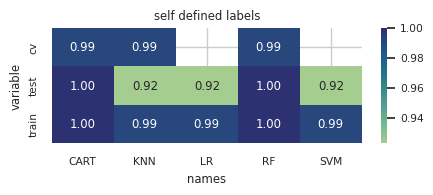

In [131]:
evals_nlp.plot_results()